In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, acf
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.stats.stattools import durbin_watson

import warnings

In [2]:
X = pd.read_csv('../data/EDA_df.csv', parse_dates = True)

In [3]:
X.index.freq = 'D'

In [4]:
X.isna().sum()

productivity      0
gnp               0
unemployment      0
core_inflation    0
inflation         0
gdp               0
gdp_potential     0
interest_rate     0
report            0
sentiment         0
dtype: int64

## Train/Test Split

In [5]:
X.drop(columns = ['report']).columns

Index(['productivity', 'gnp', 'unemployment', 'core_inflation', 'inflation',
       'gdp', 'gdp_potential', 'interest_rate', 'sentiment'],
      dtype='object')

In [6]:
X

productivity           gnp  unemployment  core_inflation  \
1970-05-20      6.215385   5055.766932      4.861290        7.111779   
1970-05-21      6.219780   5056.224370      4.864516        7.118406   
1970-05-22      6.224176   5056.681808      4.867742        7.125034   
1970-05-23      6.228571   5057.139247      4.870968        7.131661   
1970-05-24      6.232967   5057.596685      4.874194        7.138288   
...                  ...           ...           ...             ...   
2021-12-28     -5.608696  20153.853515      3.987097        3.923560   
2021-12-29     -5.706522  20154.946386      3.990323        3.939835   
2021-12-30     -5.804348  20156.039258      3.993548        3.956110   
2021-12-31     -5.902174  20157.132129      3.996774        3.972384   
2022-01-01     -6.000000  20158.225000      4.000000        3.988659   

            inflation           gdp  gdp_potential  interest_rate  \
1970-05-20   5.249699   1077.435615    5005.800307           7.95   
1970-05-21   5.245465   1077.640934    5006.230802           7.95   
1970-05-22   5.241231   1077.846253    5006.661297           7.95   
1970-05-23   5.236997   1078.051571    5007.091792           7.95   
1970-05-24   5.232763   1078.256890    5007.522287           7.95   
...               ...           ...            ...            ...   
2021-12-28   7.966581  24723.464391   20053.536280           0.08   
2021-12-29   7.975636  24727.718293   20054.622210           0.08   
2021-12-30   7.984691  24731.972196   20055.708140           0.08   
2021-12-31   7.993745  24736.226098   20056.794070           0.08   
2022-01-01   8.002800  24740.480000   20057.880000           0.08   

                                                       report  sentiment  
1970-05-20  This initial report of economic conditions in ...  -0.684800  
1970-05-21  This initial report of economic conditions in ...  -0.644979  
1970-05-22  This initial report of economic conditions in ...  -0.605157  
1970-05-23  This initial report of economic conditions in ...  -0.565336  
1970-05-24  This initial report of economic conditions in ...  -0.525514  
...                                                       ...        ...  
2021-12-28  Economic activity grew at a modest to moderate...   0.998700  
2021-12-29  Economic activity grew at a modest to moderate...   0.998767  
2021-12-30  Economic activity grew at a modest to moderate...   0.998833  
2021-12-31  Economic activity grew at a modest to moderate...   0.998900  
2022-01-01  Economic activity grew at a modest to moderate...   0.998967  

[18855 rows x 10 columns]

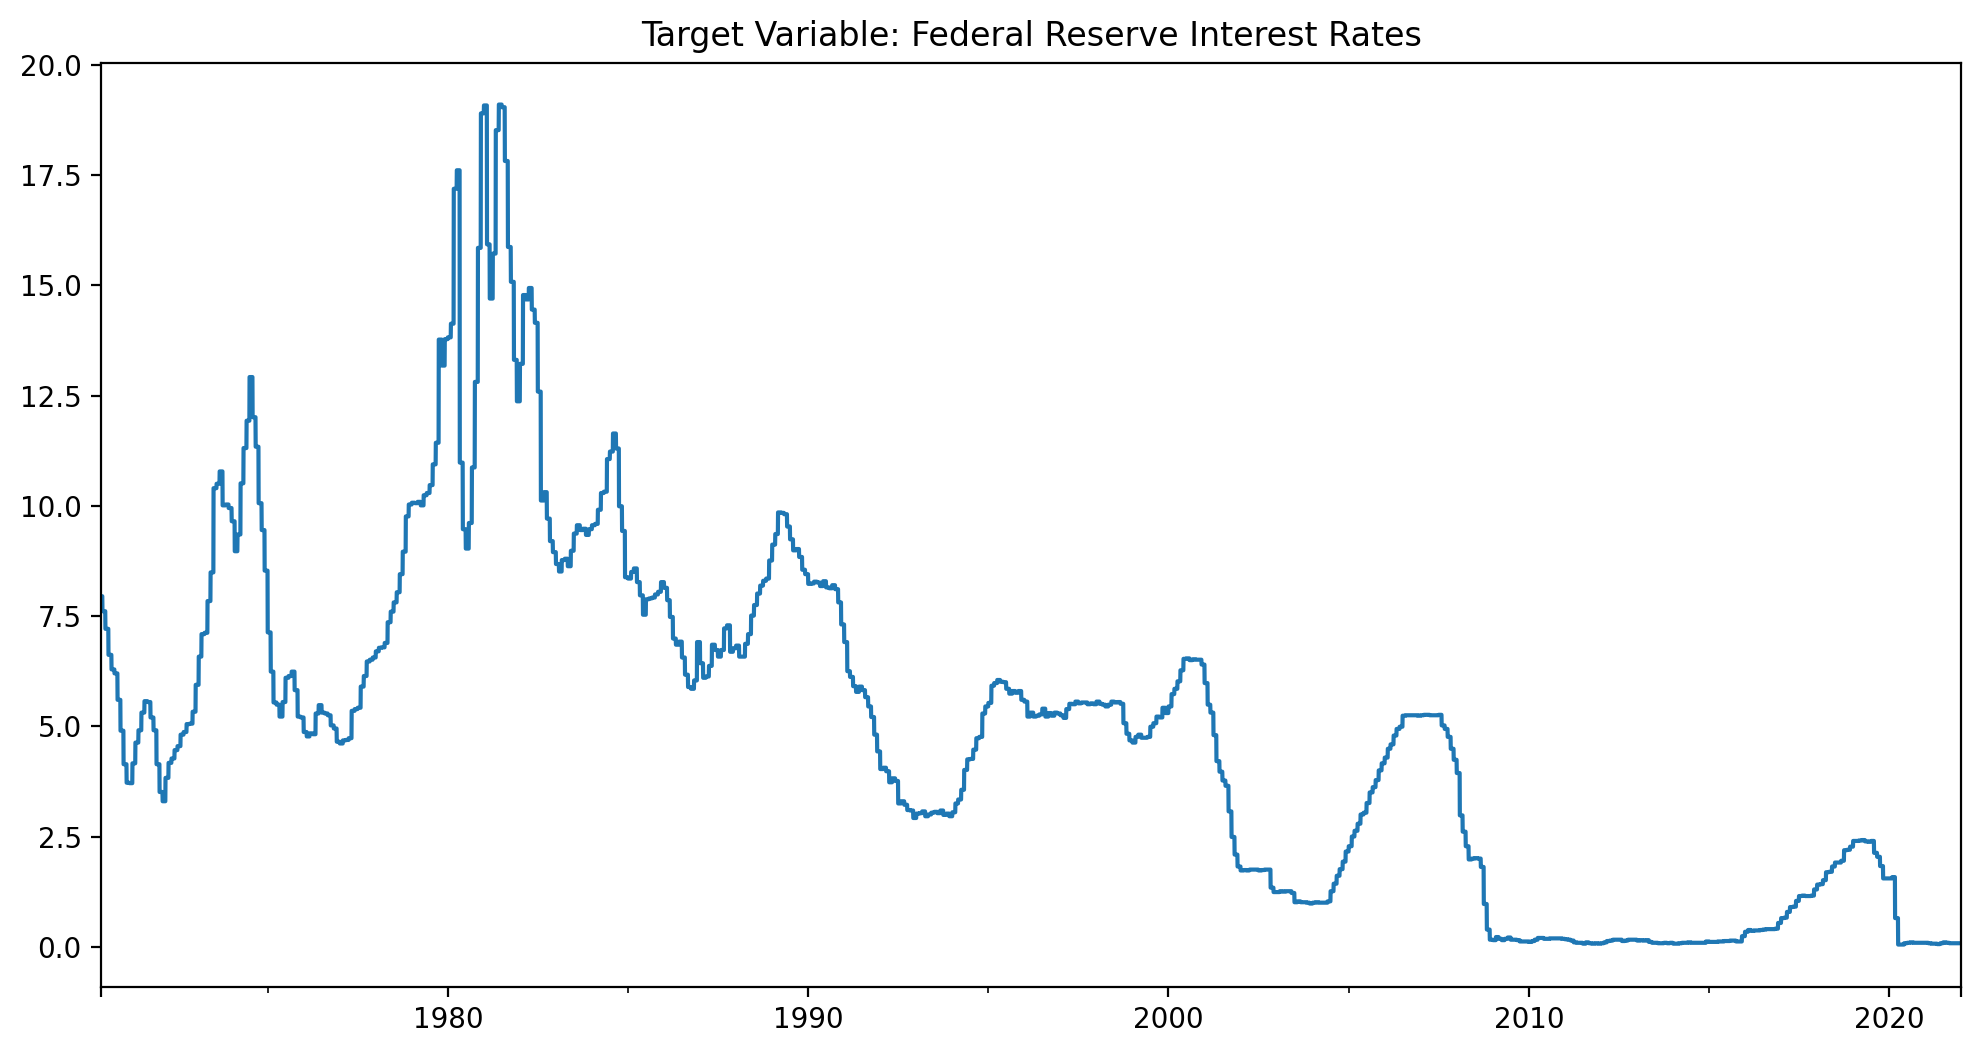

In [7]:
plt.figure(figsize = (12,6), dpi = 200)
X['interest_rate'].plot();
plt.title('Target Variable: Federal Reserve Interest Rates');

Most of the data in this timeseries is either imputed from being on a monthly or quarterly basis, meaning I will have to find a balance between the difficulty of forecasting far into the future and ensuring that the test set actually has a reasonable amount of data. I'll forecast five years ahead. For monthly data, that means I'll have 60 test observations, and 20 observations for quarterly data. Although modeling inflation, interest rates, etc. this far ahead will be very challenging, I will actually be able to score my model properly, which I would potentially not be able to do if I retained fewer test set observations.

In [8]:
split_date = '2017-01-01'

In [9]:
X_train = X.loc[:split_date]
X_test = X.loc['2017-01-02':]

In [10]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2017-01-02 to 2022-01-01
Freq: D
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   productivity    1826 non-null   float64
 1   gnp             1826 non-null   float64
 2   unemployment    1826 non-null   float64
 3   core_inflation  1826 non-null   float64
 4   inflation       1826 non-null   float64
 5   gdp             1826 non-null   float64
 6   gdp_potential   1826 non-null   float64
 7   interest_rate   1826 non-null   float64
 8   report          1826 non-null   object 
 9   sentiment       1826 non-null   float64
dtypes: float64(9), object(1)
memory usage: 156.9+ KB


In [11]:
X_train.isna().sum()

productivity      0
gnp               0
unemployment      0
core_inflation    0
inflation         0
gdp               0
gdp_potential     0
interest_rate     0
report            0
sentiment         0
dtype: int64

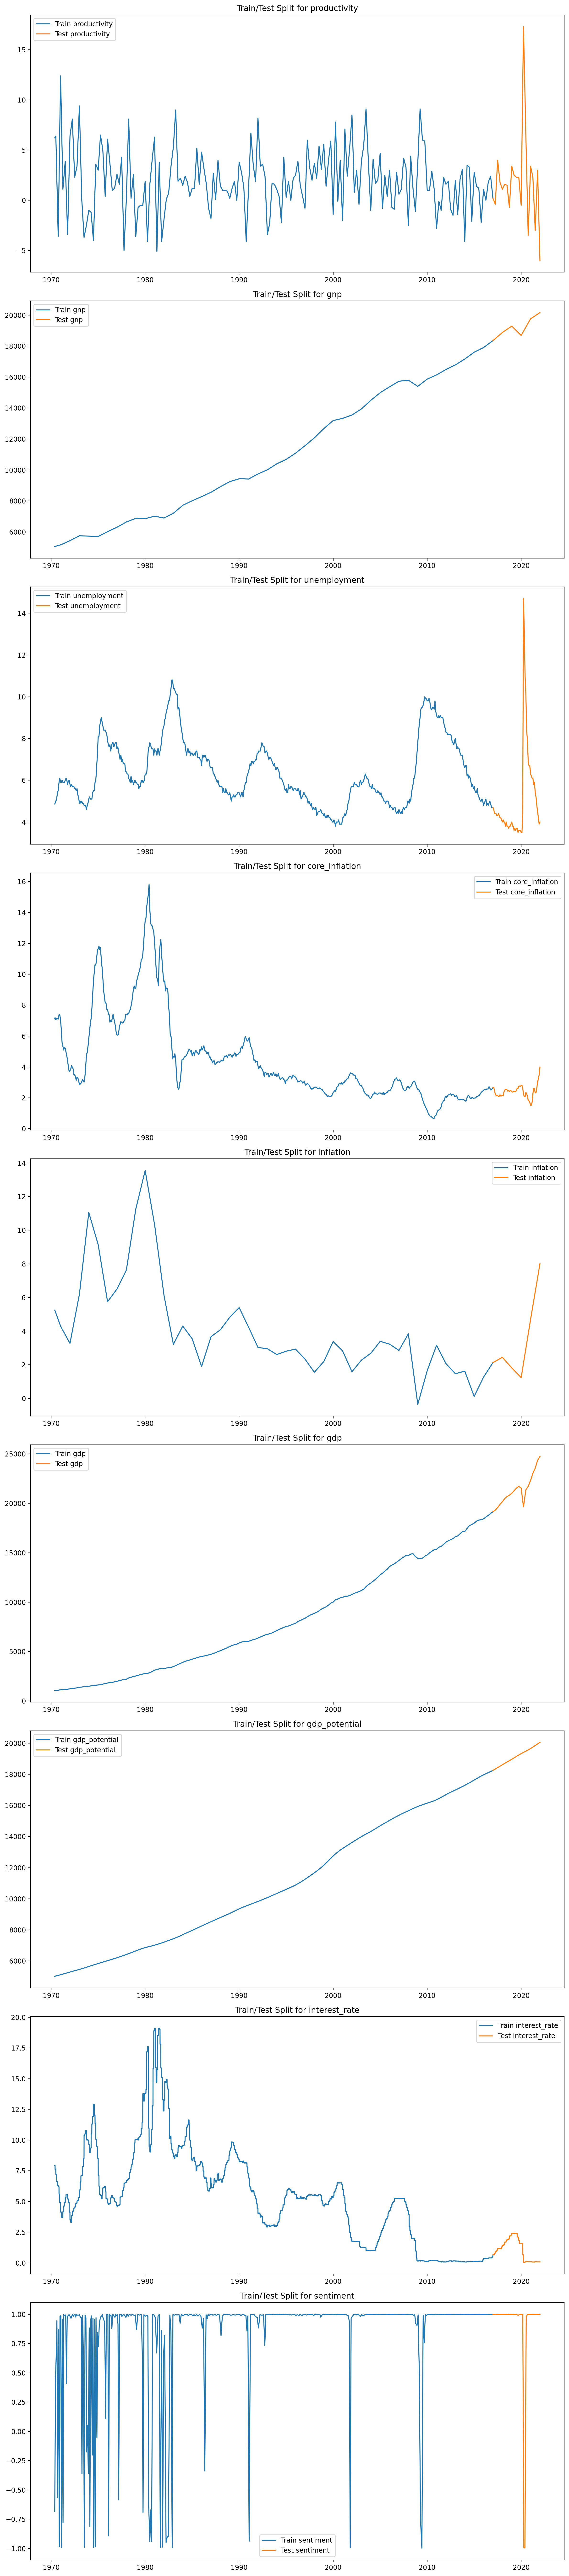

In [12]:
columns_to_plot = X.drop(columns=['report']).columns

num_rows = len(columns_to_plot)
num_cols = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows), dpi=200)

for i, column in enumerate(columns_to_plot):
    row = i
    col = 0

    axes[row].plot(X_train[column], label = f"Train {column}")
    axes[row].plot(X_test[column], label = f"Test {column}")

    axes[row].set_title(f'Train/Test Split for {column}')
    axes[row].legend()
    
plt.tight_layout()

In [13]:
X_train.tail()

productivity           gnp  unemployment  core_inflation  \
2016-12-28      0.295652  18345.839525           4.7        2.652966   
2016-12-29      0.271739  18347.065893           4.7        2.655115   
2016-12-30      0.247826  18348.292262           4.7        2.657264   
2016-12-31      0.223913  18349.518631           4.7        2.659413   
2017-01-01      0.200000  18350.745000           4.7        2.661562   

            inflation           gdp  gdp_potential  interest_rate  \
2016-12-28   2.120618  19140.361261   18254.749525           0.54   
2016-12-29   2.122991  19142.319446   18255.567913           0.54   
2016-12-30   2.125364  19144.277630   18256.386301           0.54   
2016-12-31   2.127737  19146.235815   18257.204689           0.54   
2017-01-01   2.130110  19148.194000   18258.023077           0.65   

                                                       report  sentiment  
2016-12-28  Reports from the twelve Federal Reserve Distri...   0.999257  
2016-12-29  Reports from the twelve Federal Reserve Distri...   0.999245  
2016-12-30  Reports from the twelve Federal Reserve Distri...   0.999233  
2016-12-31  Reports from the twelve Federal Reserve Distri...   0.999220  
2017-01-01  Reports from the twelve Federal Reserve Distri...   0.999208

In [14]:
X_test.head()

productivity           gnp  unemployment  core_inflation  \
2017-01-02      0.193333  18352.180712      4.696774        2.661978   
2017-01-03      0.186667  18353.616425      4.693548        2.662394   
2017-01-04      0.180000  18355.052137      4.690323        2.662810   
2017-01-05      0.173333  18356.487849      4.687097        2.663226   
2017-01-06      0.166667  18357.923562      4.683871        2.663642   

            inflation         gdp  gdp_potential  interest_rate  \
2017-01-02   2.130966  19149.9308   18258.946057           0.65   
2017-01-03   2.131822  19151.6676   18259.869038           0.65   
2017-01-04   2.132678  19153.4044   18260.792018           0.65   
2017-01-05   2.133534  19155.1412   18261.714998           0.65   
2017-01-06   2.134390  19156.8780   18262.637978           0.65   

                                                       report  sentiment  
2017-01-02  Reports from the twelve Federal Reserve Distri...   0.999196  
2017-01-03  Reports from the twelve Federal Reserve Distri...   0.999184  
2017-01-04  Reports from the twelve Federal Reserve Distri...   0.999171  
2017-01-05  Reports from the twelve Federal Reserve Distri...   0.999159  
2017-01-06  Reports from the twelve Federal Reserve Distri...   0.999147

## Baseline Model:

My baseline model will carry the last observation of the training set forward:

In [15]:
X_train['interest_rate'].loc[split_date]

0.65

In [16]:
X_test.shape[0]

1826

In [17]:
baseline_df = pd.DataFrame()
for column in X_test.drop(columns = ['report']).columns:
    baseline_df = baseline_df.join(pd.DataFrame(index = X_test.index, columns = [f"{column}"],
                               data = np.full_like(X_test[column], X_train[column].loc[split_date])),
                                  how = 'right')
baseline_df.head()

productivity        gnp  unemployment  core_inflation  inflation  \
2017-01-02           0.2  18350.745           4.7        2.661562    2.13011   
2017-01-03           0.2  18350.745           4.7        2.661562    2.13011   
2017-01-04           0.2  18350.745           4.7        2.661562    2.13011   
2017-01-05           0.2  18350.745           4.7        2.661562    2.13011   
2017-01-06           0.2  18350.745           4.7        2.661562    2.13011   

                  gdp  gdp_potential  interest_rate  sentiment  
2017-01-02  19148.194   18258.023077           0.65   0.999208  
2017-01-03  19148.194   18258.023077           0.65   0.999208  
2017-01-04  19148.194   18258.023077           0.65   0.999208  
2017-01-05  19148.194   18258.023077           0.65   0.999208  
2017-01-06  19148.194   18258.023077           0.65   0.999208

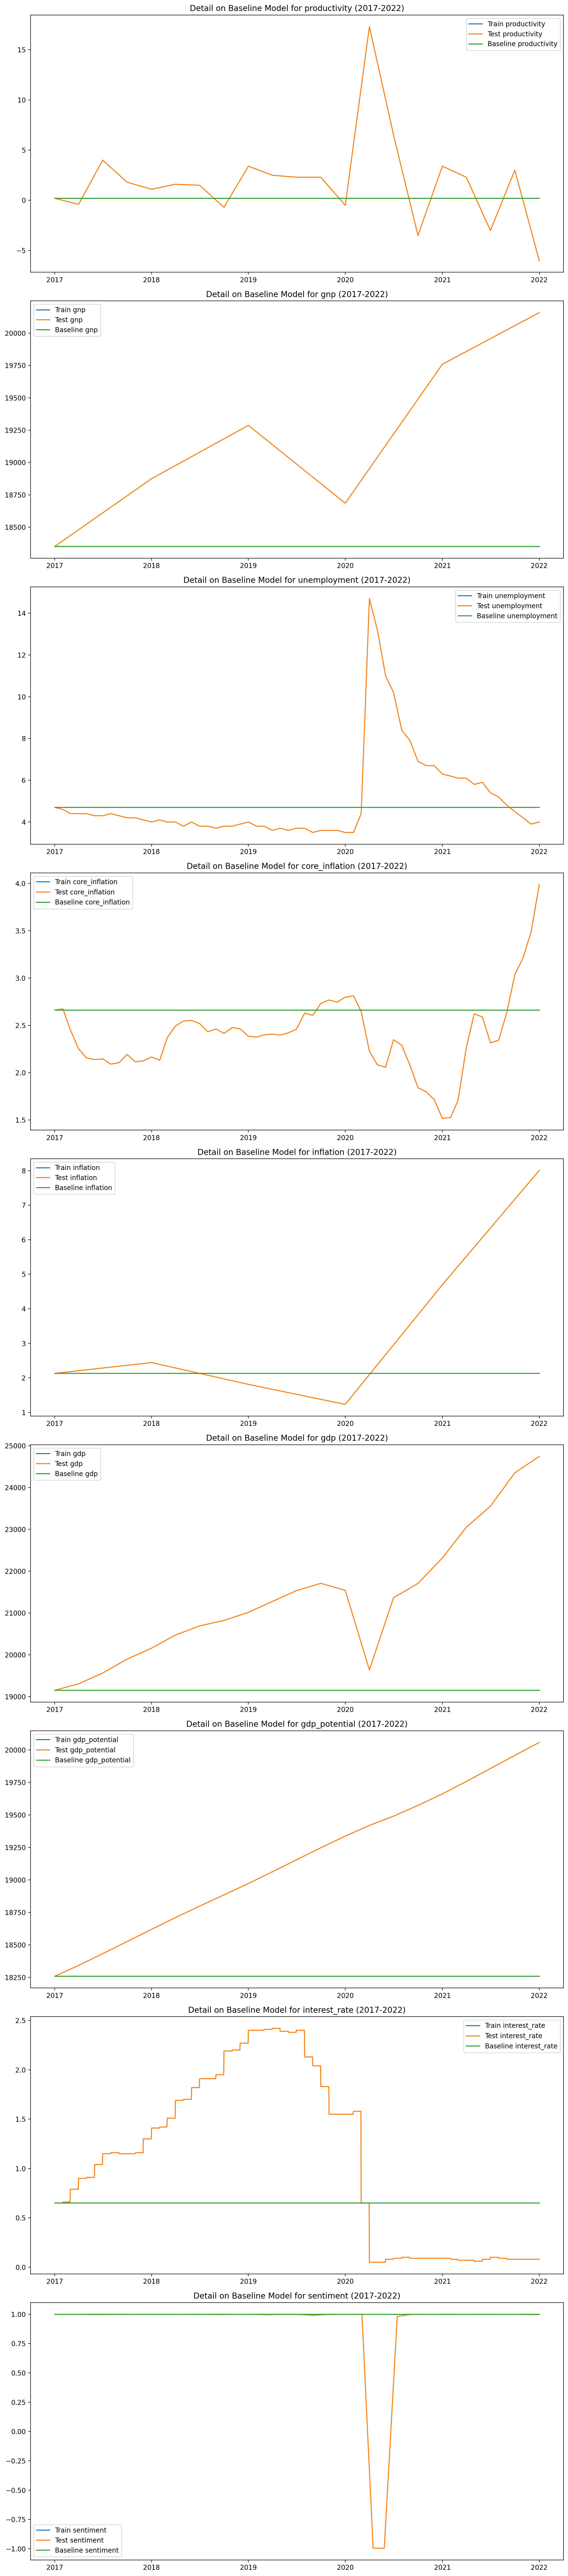

In [18]:
columns_to_plot = X.drop(columns = ['report']).columns

num_rows = len(columns_to_plot)
num_cols = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows), dpi = 200)

for i, column in enumerate(columns_to_plot):
    row = i
    
    axes[row].plot(X_train[column].loc['2017-01-01':split_date], label = f"Train {column}")
    axes[row].plot(X_test[column], label = f"Test {column}")
    axes[row].plot(baseline_df[column], label = f"Baseline {column}")
        
    axes[row].set_title(f'Detail on Baseline Model for {column} (2017-2022)')
    axes[row].legend()
    
plt.tight_layout()

In [19]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2017-01-02 to 2022-01-01
Freq: D
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   productivity    1826 non-null   float64
 1   gnp             1826 non-null   float64
 2   unemployment    1826 non-null   float64
 3   core_inflation  1826 non-null   float64
 4   inflation       1826 non-null   float64
 5   gdp             1826 non-null   float64
 6   gdp_potential   1826 non-null   float64
 7   interest_rate   1826 non-null   float64
 8   report          1826 non-null   object 
 9   sentiment       1826 non-null   float64
dtypes: float64(9), object(1)
memory usage: 221.5+ KB


I'll create a TVEC of the report data at the end. For now, I'll leave off the `report` feature.

In [20]:
X_train_numeric = X_train.drop(columns = ['report'])
X_test_numeric = X_test.drop(columns = ['report'])

In [21]:
X_train_numeric.head(2)

productivity          gnp  unemployment  core_inflation  \
1970-05-20      6.215385  5055.766932      4.861290        7.111779   
1970-05-21      6.219780  5056.224370      4.864516        7.118406   

            inflation          gdp  gdp_potential  interest_rate  sentiment  
1970-05-20   5.249699  1077.435615    5005.800307           7.95  -0.684800  
1970-05-21   5.245465  1077.640934    5006.230802           7.95  -0.644979

In [22]:
X_train_numeric.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17029 entries, 1970-05-20 to 2017-01-01
Freq: D
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   productivity    17029 non-null  float64
 1   gnp             17029 non-null  float64
 2   unemployment    17029 non-null  float64
 3   core_inflation  17029 non-null  float64
 4   inflation       17029 non-null  float64
 5   gdp             17029 non-null  float64
 6   gdp_potential   17029 non-null  float64
 7   interest_rate   17029 non-null  float64
 8   sentiment       17029 non-null  float64
dtypes: float64(9)
memory usage: 1.8 MB


## Augmented Dickey-Fuller Test

In [23]:
#via https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
warnings.simplefilter(action='ignore', category=FutureWarning)
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   

In [24]:
for column in X_train_numeric.columns:
    adfuller_test(X_train_numeric[column], name = column)
    print('\n')

    Augmented Dickey-Fuller Test on "productivity" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.1966
 No. Lags Chosen       = 1
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "gnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.8807
 No. Lags Chosen       = 1
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.9928. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "unemployment" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-St

Productivity, unemployment, inflation, and the sentiment of the Beige Book transcripts have not changed over time, according to this test. Looking at the plots generated above, this makes sense. GNP, GDP and Potential GDP are all non-stationary which also makes sense, as these metrics tend to grow over time. However, interest rates were also found to be non-stationary:

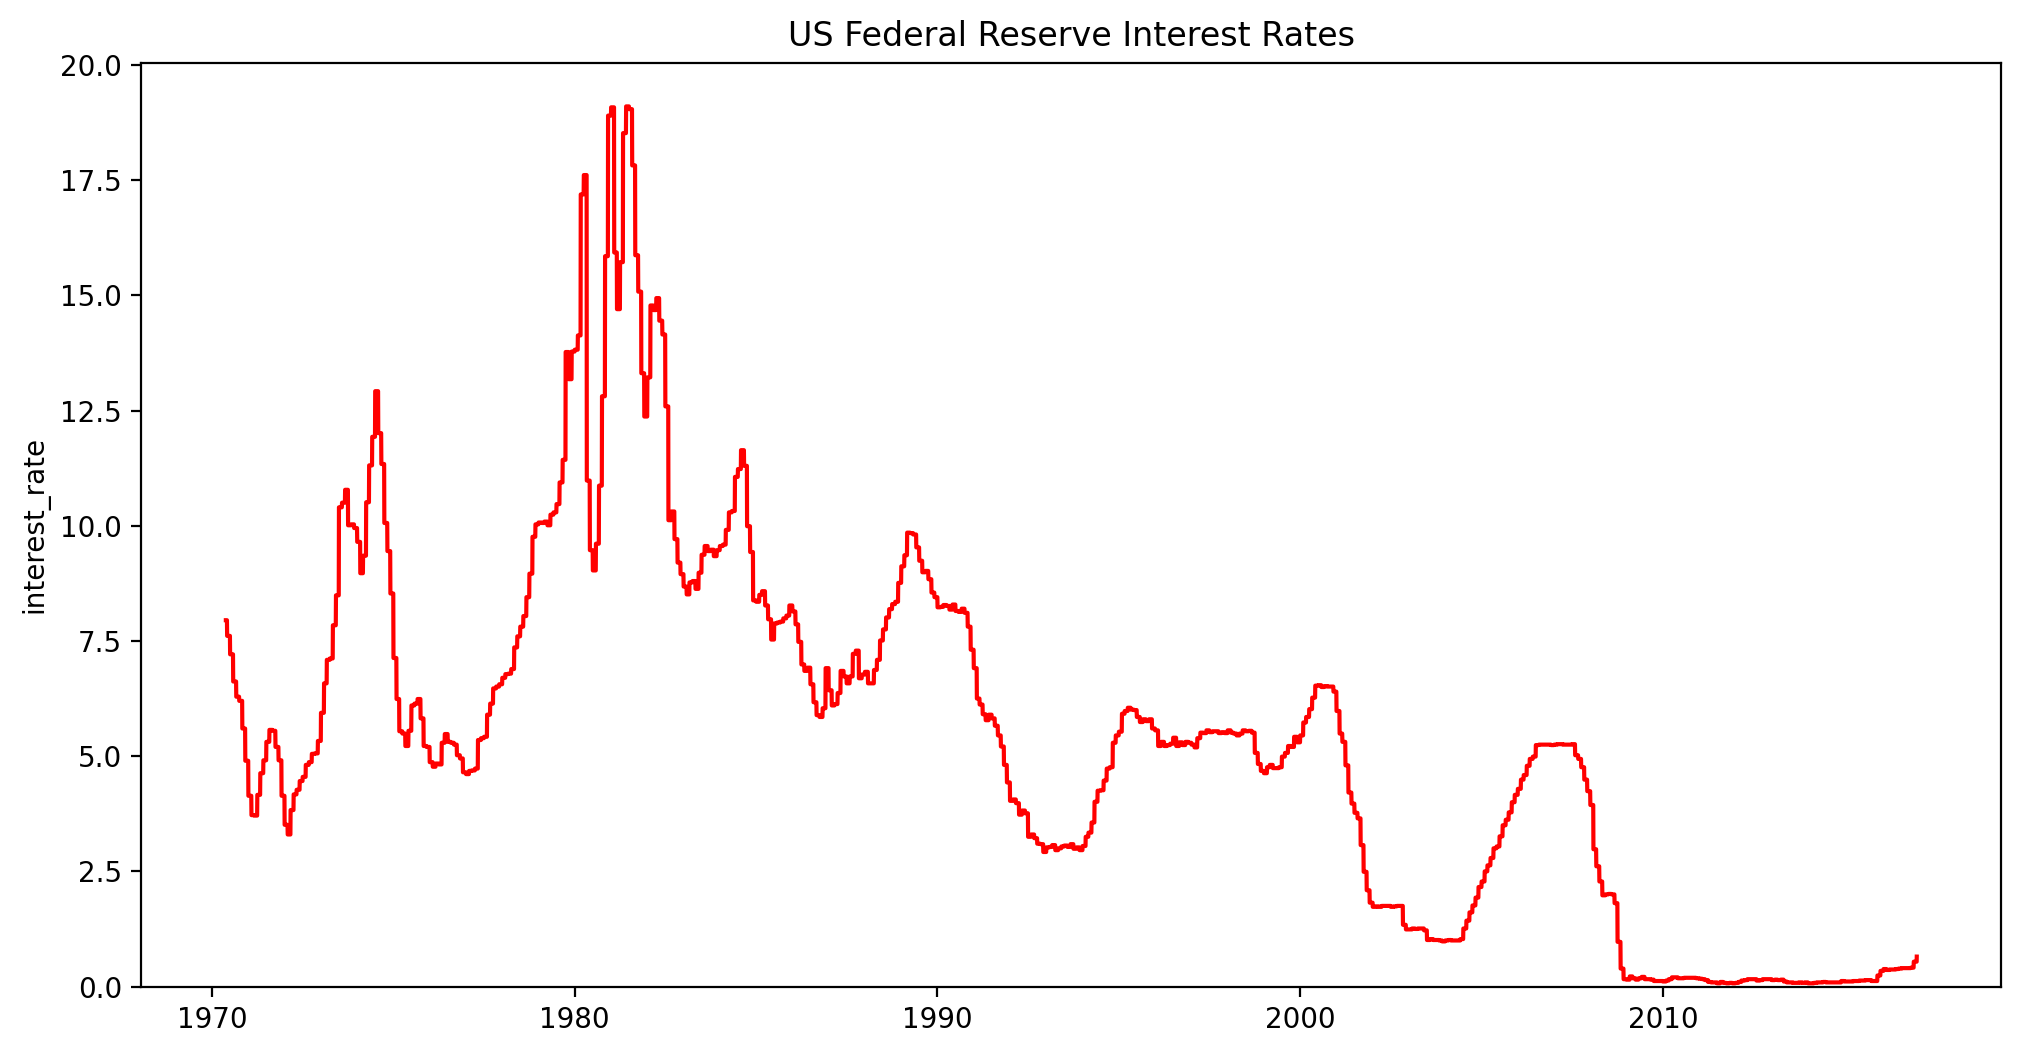

In [25]:
plt.figure(figsize = (12, 6), dpi = 200)
sns.lineplot(X_train['interest_rate'], color = 'red');
plt.title('US Federal Reserve Interest Rates');
plt.ylim(0,);

There does appear to be a general downward trend in interest rates over time. The remaining non-stationary metric is core inflation:


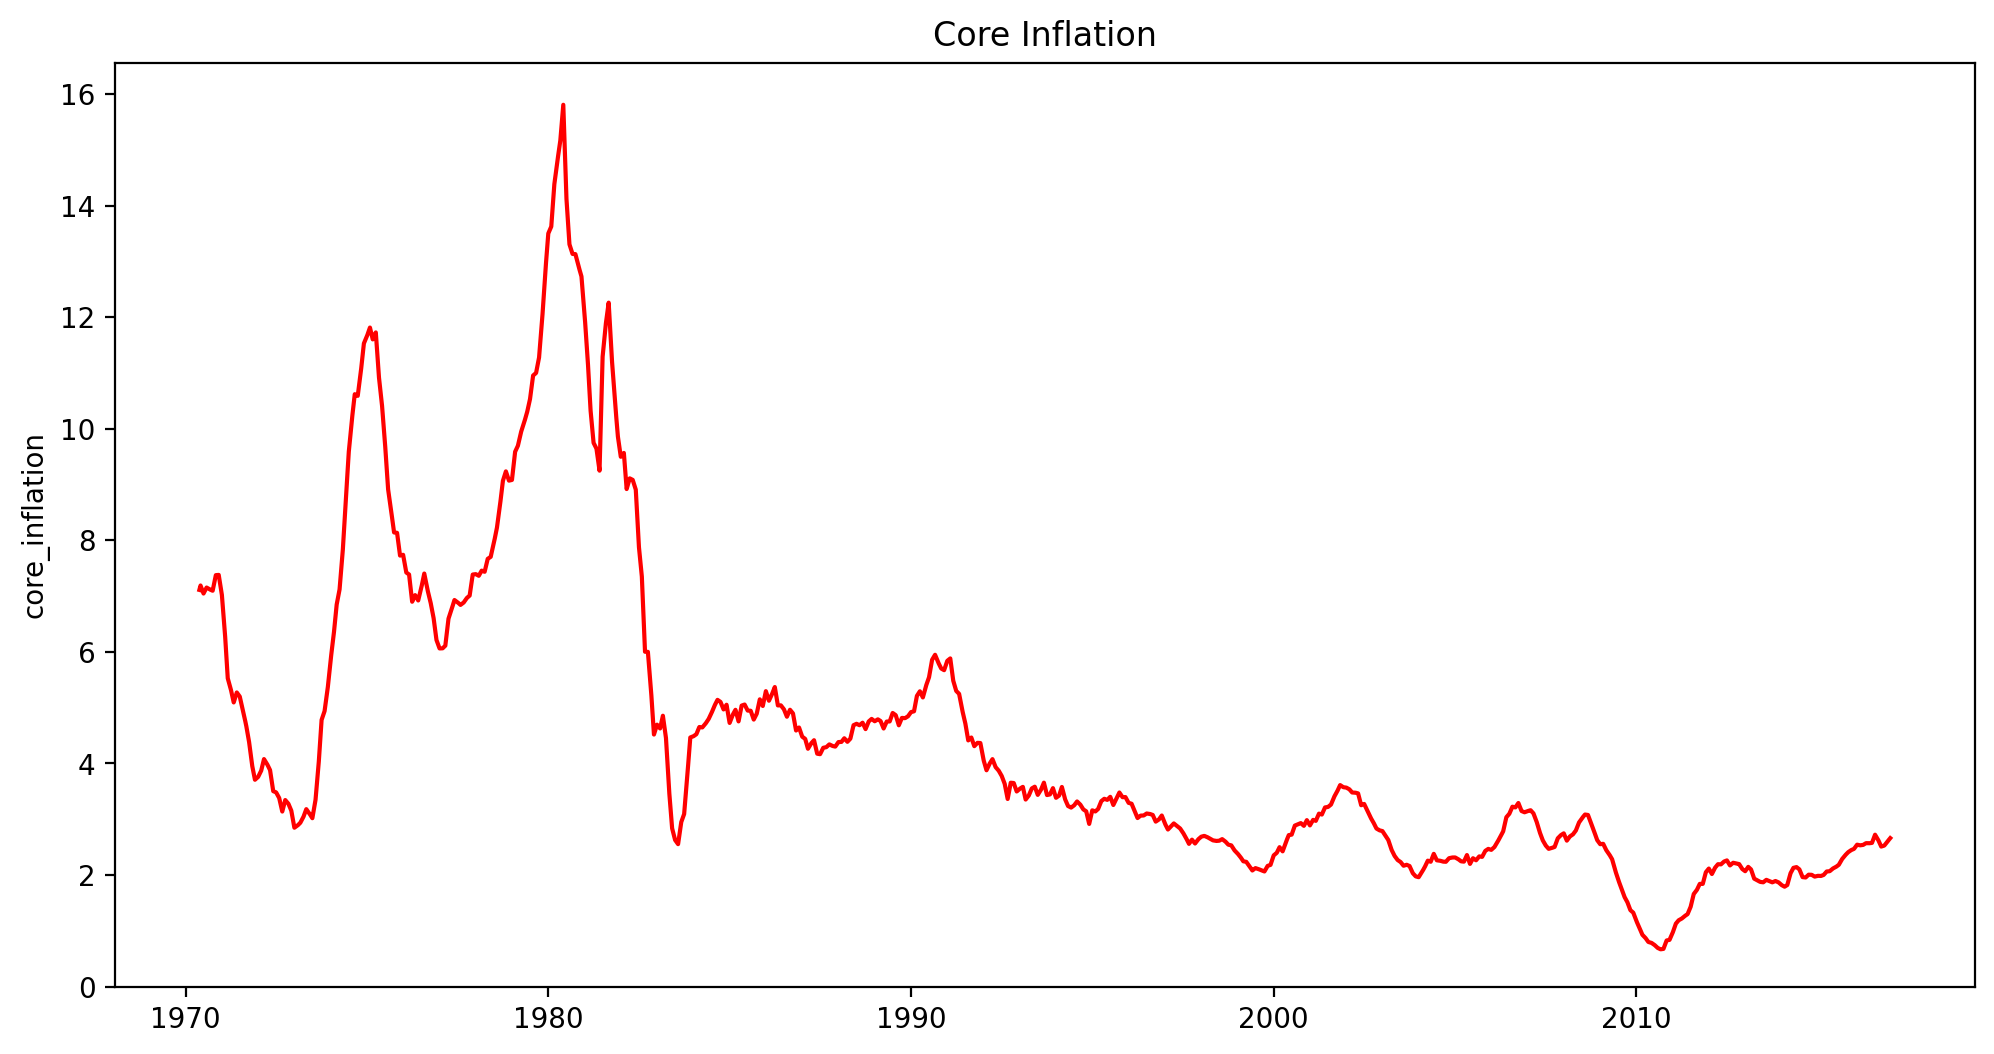

In [26]:
plt.figure(figsize = (12, 6), dpi = 200)
sns.lineplot(X_train_numeric['core_inflation'], color = 'red');
plt.title('Core Inflation');
plt.ylim(0,);

https://www.federalreservehistory.org/essays/great-inflation</br>
Unlike broader inflation, this metric was considered to have a general trend, also downward over time. This is surprising, as during the 1980s, oil prices skyrocketed, likely causing the downward trend in comparison to that period:

    "The first crisis was an Arab oil embargo that began in October 1973 and lasted about five months. During this period, crude oil prices quadrupled to a plateau that held until the Iranian revolution brought a second energy crisis in 1979. The second crisis tripled the cost of oil."
    
However, oil and food prices are excluded in calculating core inflation. In reality, inflation probably has a more pronounced trend than core inflation, as the entire point of the core inflation metric is that analyzes a less volitile set of commodities. The categorization of inflation as stationary could be down to the fact that there's a relatively small amount of granularity in the data:

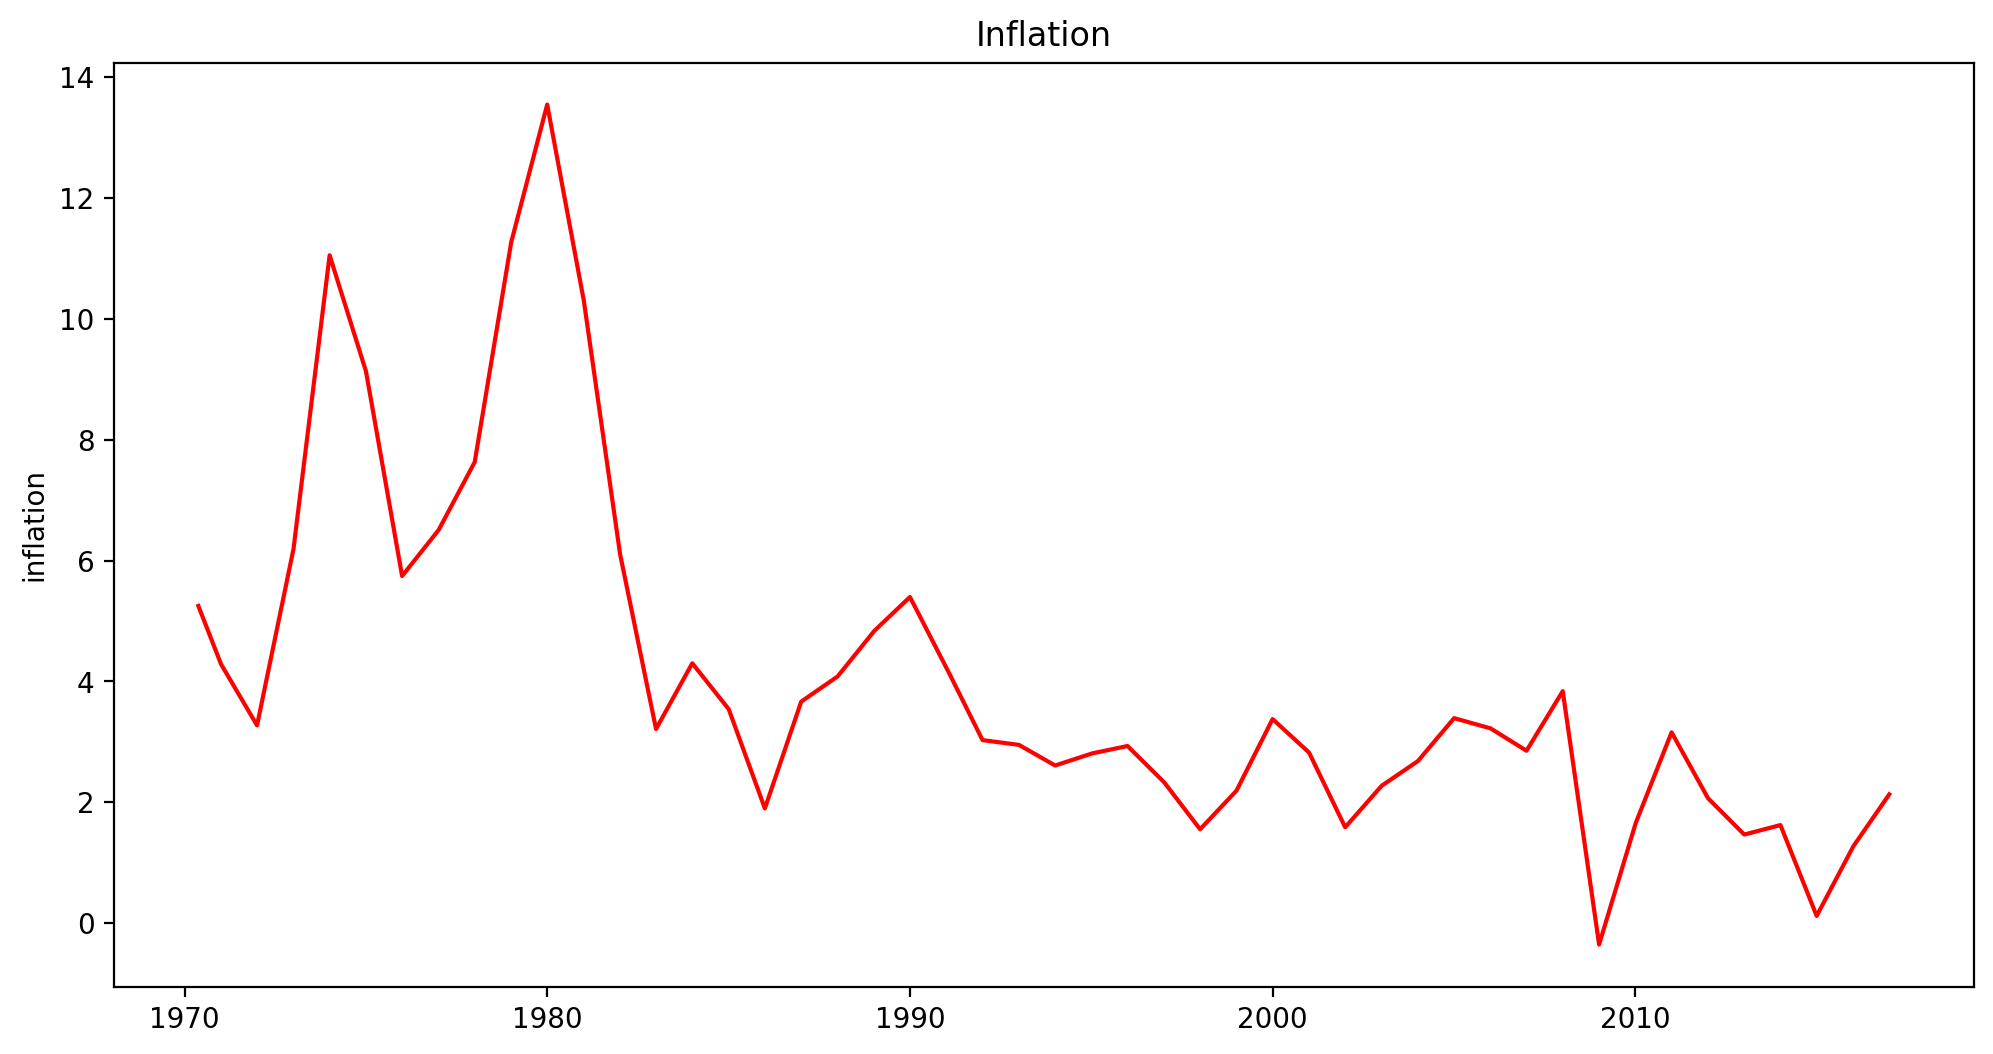

In [27]:
plt.figure(figsize = (12, 6), dpi = 200)
sns.lineplot(X_train_numeric['inflation'], color = 'red');
plt.title('Inflation');

## Differencing

The goal of differencing is to simulate stationarity.

In [28]:
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
X_train_differenced = X_train_numeric.diff().dropna()

In [29]:
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
for column in X_train_differenced.columns:
    adfuller_test(X_train_differenced[column], name = column)
    print('\n')

    Augmented Dickey-Fuller Test on "productivity" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.0311
 No. Lags Chosen       = 0
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "gnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.0041
 No. Lags Chosen       = 0
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0014. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "unemployment" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significan

All the features are now stationary, except for potential GDP. Since I already have a feature related to GDP, I will drop potential GDP rather than difference again, which can induce variance and model complexity.

In [30]:
X_train_differenced.drop(columns = ['gdp_potential'], inplace = True)

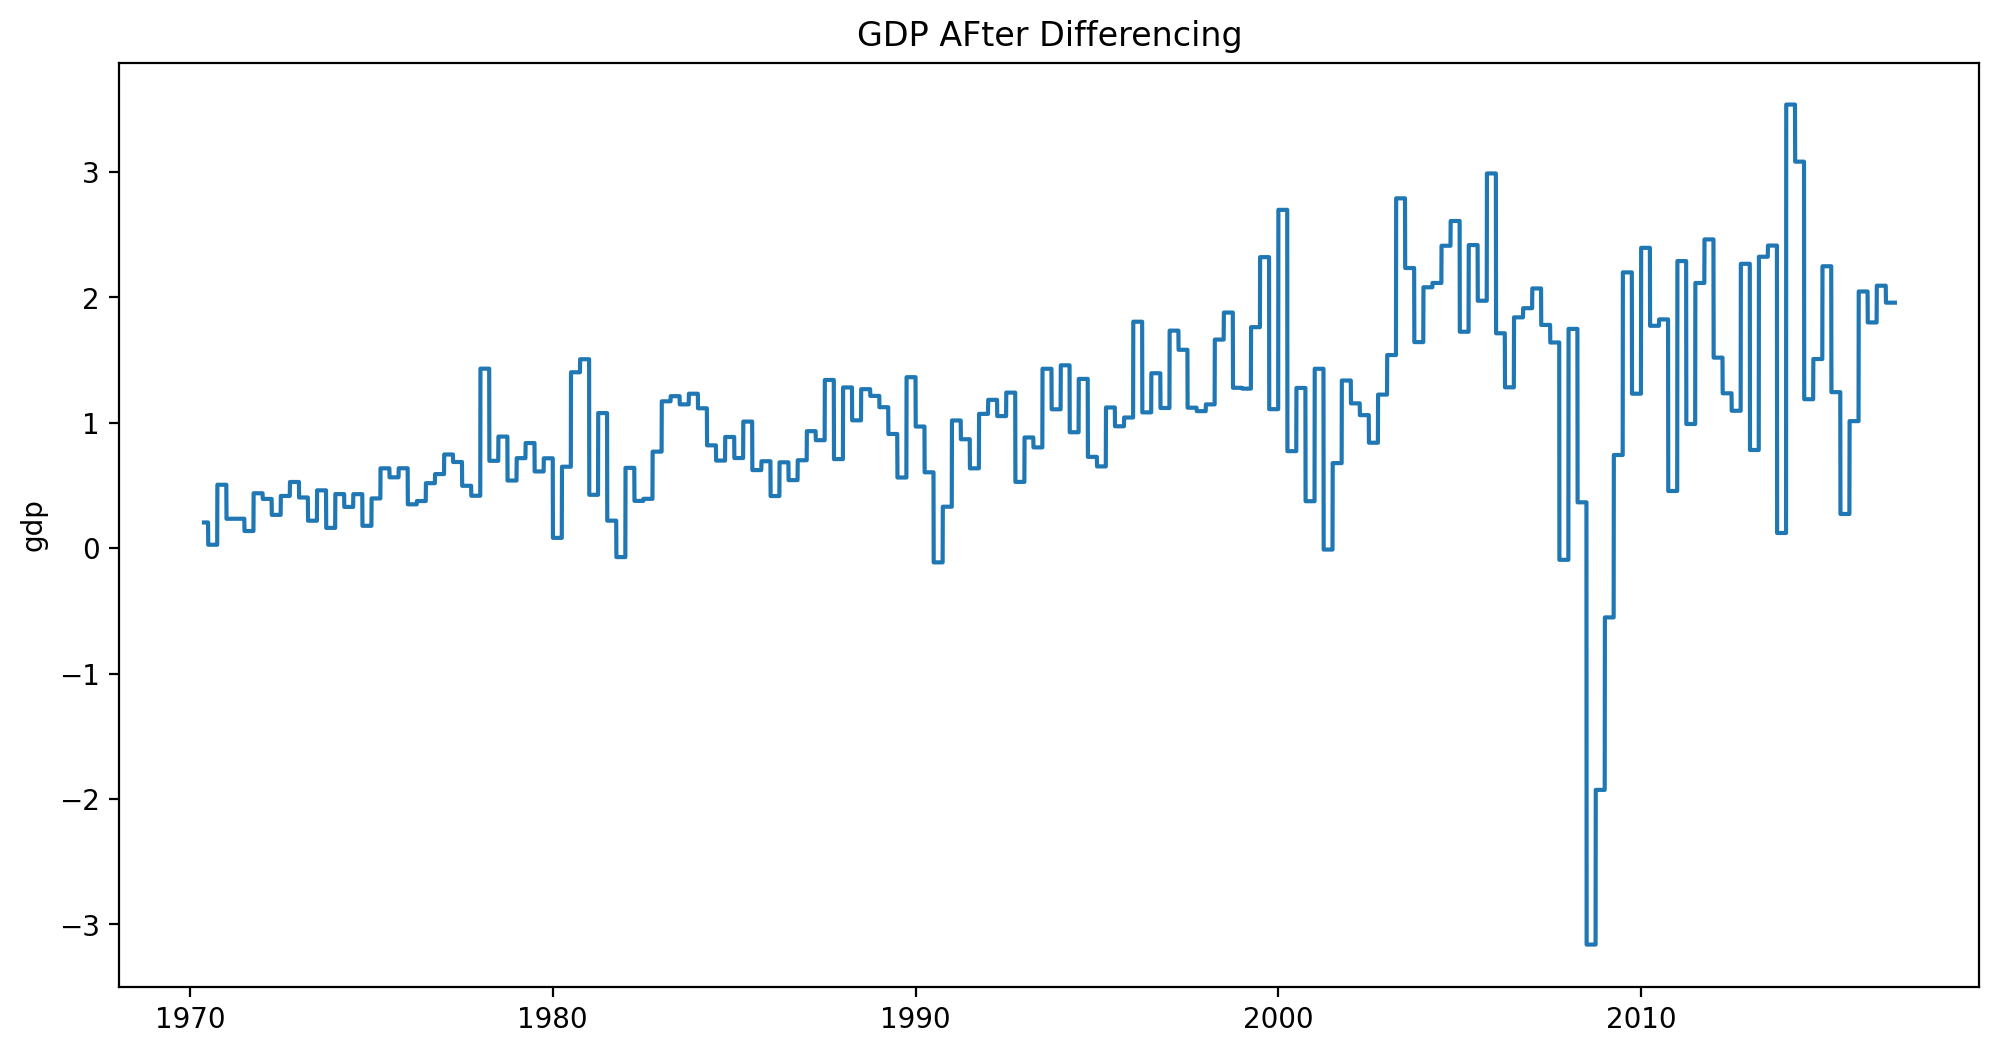

In [31]:
plt.figure(figsize = (12, 6), dpi = 200)
sns.lineplot(X_train_differenced['gdp']);
plt.title('GDP AFter Differencing');

## Order Selection

In [32]:
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
model = VAR(X_train_differenced)
x = model.select_order(maxlags = 5)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

1 lag is considered to be the best balance between lowest AIC and lowest number of lags, i.e. reducing variance.


## Fitting the Vector Autoregression Model

The model selection tool above indicated that I should pick an order of 1, so that's what I'll try first.

In [33]:
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
model_fitted = model.fit(1)

## Checking for Serial Correlation

Checking for any remaining autocorrelation between features using the Durban-Watson test:

In [34]:
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
out = durbin_watson(model_fitted.resid)

for col, val in zip(X_train_differenced.columns, out):
    print(col, ':', round(val, 2))

productivity : 1.98
gnp : 2.0
unemployment : 1.97
core_inflation : 1.98
inflation : 2.0
gdp : 1.99
interest_rate : 2.0
sentiment : 1.95


Fitting with a model order of 1 is giving scores very close to 2, which makes sense as during the EDA phase when I was performing the PACF and ACF tests, I observed that lags of 1 and 2 had a very high correlation, so de-correlating 1 lag would also have a strong effect.

In [35]:
model_fitted = model.fit(2)
out = durbin_watson(model_fitted.resid)

for col, val in zip(X_train_differenced.columns, out):
    print(col, ':', round(val, 2))

productivity : 2.0
gnp : 2.0
unemployment : 2.0
core_inflation : 2.0
inflation : 2.0
gdp : 2.0
interest_rate : 2.0
sentiment : 2.0


A model order of 2 gives even better performance, although this risks overfitting. I'm going to go with an order of 2 for now, as like I mentioned, lags 1 and 2 both had extremely high autocorrelation in the PACF and ACF tests.

In [36]:
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
lag_order = model_fitted.k_ar
lag_order

2

In [37]:
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
forecast_input = X_train_differenced.values[-lag_order:]
forecast_input

array([[-2.39130435e-02,  1.22636885e+00,  0.00000000e+00,
         2.14896774e-03,  2.37302404e-03,  1.95818478e+00,
         0.00000000e+00, -1.22448980e-05],
       [-2.39130435e-02,  1.22636885e+00,  0.00000000e+00,
         2.14896774e-03,  2.37302404e-03,  1.95818478e+00,
         1.10000000e-01, -1.22448980e-05]])

In [38]:
X_test.drop(columns = ['gdp_potential', 'report'], inplace = True)

C:\Users\User\AppData\Local\Temp\ipykernel_21388\2529601539.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(columns = ['gdp_potential', 'report'], inplace = True)


In [39]:
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
fc = model_fitted.forecast(y = forecast_input, steps = len(X_test))
df_forecast = pd.DataFrame(fc, index = X_test.index, 
                           columns = X_test.columns + '_1d')
df_forecast.head()

productivity_1d    gnp_1d  unemployment_1d  core_inflation_1d  \
2017-01-02        -0.023291  1.223852         0.000035           0.002246   
2017-01-03        -0.022956  1.222476        -0.000042           0.002212   
2017-01-04        -0.022628  1.221063        -0.000114           0.002174   
2017-01-05        -0.022308  1.219652        -0.000183           0.002138   
2017-01-06        -0.021995  1.218245        -0.000249           0.002102   

            inflation_1d    gdp_1d  interest_rate_1d  sentiment_1d  
2017-01-02      0.002363  1.955870          0.002688     -0.000084  
2017-01-03      0.002350  1.953567          0.002687     -0.000148  
2017-01-04      0.002336  1.951183          0.002964     -0.000213  
2017-01-05      0.002323  1.948791          0.002980     -0.000273  
2017-01-06      0.002309  1.946394          0.002995     -0.000328

## Reversing the Differencing

In [40]:
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [41]:
df_fc = invert_transformation(X_train.drop(columns = ['gdp_potential', 'report']), df_forecast, second_diff = False)
df_fc.head()

productivity_1d    gnp_1d  unemployment_1d  core_inflation_1d  \
2017-01-02        -0.023291  1.223852         0.000035           0.002246   
2017-01-03        -0.022956  1.222476        -0.000042           0.002212   
2017-01-04        -0.022628  1.221063        -0.000114           0.002174   
2017-01-05        -0.022308  1.219652        -0.000183           0.002138   
2017-01-06        -0.021995  1.218245        -0.000249           0.002102   

            inflation_1d    gdp_1d  interest_rate_1d  sentiment_1d  \
2017-01-02      0.002363  1.955870          0.002688     -0.000084   
2017-01-03      0.002350  1.953567          0.002687     -0.000148   
2017-01-04      0.002336  1.951183          0.002964     -0.000213   
2017-01-05      0.002323  1.948791          0.002980     -0.000273   
2017-01-06      0.002309  1.946394          0.002995     -0.000328   

            productivity_forecast  gnp_forecast  unemployment_forecast  \
2017-01-02               0.176709  18351.968852               4.700035   
2017-01-03               0.153753  18353.191329               4.699993   
2017-01-04               0.131125  18354.412392               4.699879   
2017-01-05               0.108818  18355.632043               4.699696   
2017-01-06               0.086822  18356.850288               4.699447   

            core_inflation_forecast  inflation_forecast  gdp_forecast  \
2017-01-02                 2.663808            2.132473  19150.149870   
2017-01-03                 2.666020            2.134823  19152.103438   
2017-01-04                 2.668195            2.137159  19154.054621   
2017-01-05                 2.670332            2.139482  19156.003412   
2017-01-06                 2.672434            2.141791  19157.949806   

            interest_rate_forecast  sentiment_forecast  
2017-01-02                0.652688            0.999124  
2017-01-03                0.655374            0.998976  
2017-01-04                0.658338            0.998763  
2017-01-05                0.661318            0.998489  
2017-01-06                0.664313            0.998161

In [42]:
X_test.columns

Index(['productivity', 'gnp', 'unemployment', 'core_inflation', 'inflation',
       'gdp', 'interest_rate', 'sentiment'],
      dtype='object')

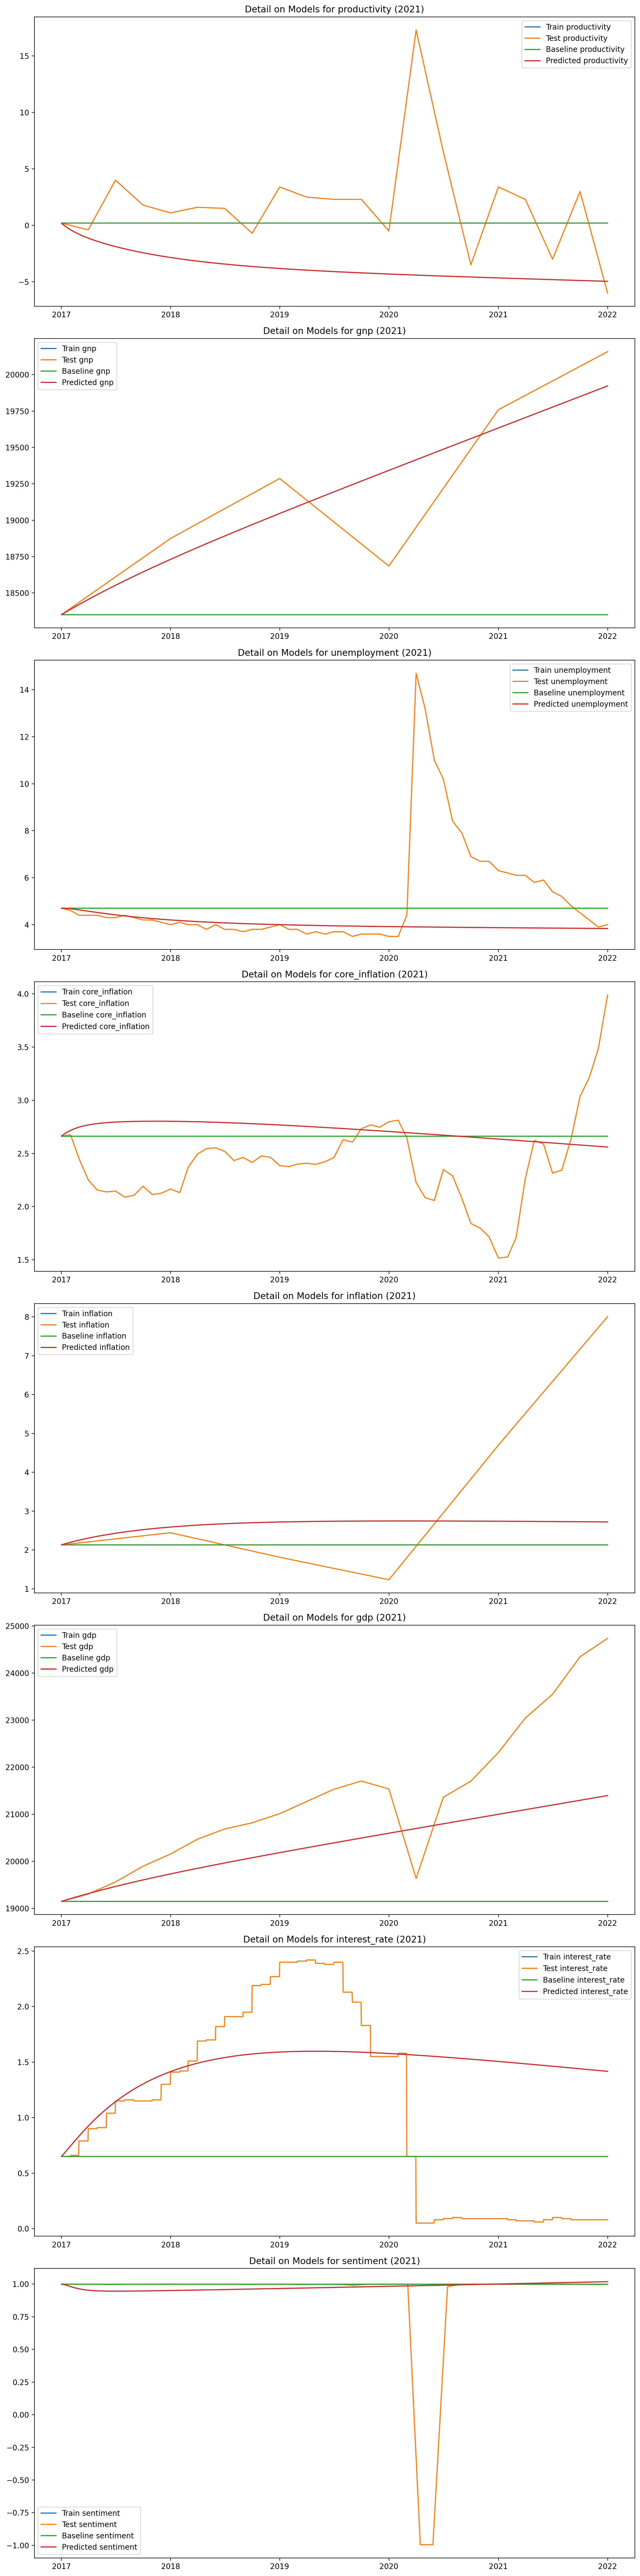

In [43]:
columns_to_plot = X_test.columns

num_rows = len(columns_to_plot)
num_cols = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows), dpi=200)

for i, column in enumerate(columns_to_plot):
    row = i

    axes[row].plot(X_train[column].loc['2021-01-01':split_date], label = f"Train {column}")
    axes[row].plot(X_test[column], label = f"Test {column}")
    axes[row].plot(baseline_df[column], label = f"Baseline {column}")
    axes[row].plot(df_fc[f"{column}_forecast"], label = f"Predicted {column}")

    axes[row].set_title(f'Detail on Models for {column} (2021)')
    axes[row].legend()
    
plt.tight_layout()

## Evaluating Model Performance

In [45]:
var_scores = pd.DataFrame()
var_scores['model'] = ['VAR']
var_scores['scoring_metric'] = ['mape']

for column in X_train_differenced.columns:
    forecast = df_fc[f"{column}_forecast"]
    actual = X_test[column]
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))
    var_scores[column] = [mape]
var_scores.head()

model scoring_metric  productivity      gnp  unemployment  core_inflation  \
0   VAR           mape           inf  0.01037      0.174319        0.198223   

   inflation       gdp  interest_rate  sentiment  
0   0.406716  0.044659       6.538169   0.584056

In [46]:
# https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

base_scores = pd.DataFrame()
base_scores['model'] = ['baseline']
base_scores['scoring_metric'] = ['mape']

for column in X_train_differenced.columns:
    forecast = baseline_df[column]
    actual = X_test[column]
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))
    base_scores[column] = [mape]
    
scores = pd.DataFrame()
scores = pd.concat([base_scores, var_scores])
scores.index  = range(0,len(scores))
scores

model scoring_metric  productivity       gnp  unemployment  \
0  baseline           mape           inf  0.042277      0.231195   
1       VAR           mape           inf  0.010370      0.174319   

   core_inflation  inflation       gdp  interest_rate  sentiment  
0        0.174576   0.309503  0.097101       2.935671   0.566328  
1        0.198223   0.406716  0.044659       6.538169   0.584056

**Interpreting MAPE**

https://www.statology.org/mape-excel/</br>
Via statology.com:

    "MAPE is commonly used because it’s easy to interpret and easy to explain. For example, a MAPE value of 11.5% means that the average difference between the forecasted value and the actual value is 11.5%."
    
A lower value of MAPE is preferable, since it's essentially measuring the percentage of error present. Productivity has an infinitely high MAPE, which is likely because when I calculated mape in this line:


    `mape = np.mean(np.abs(forecast - actual) / np.abs(actual))`
    
if `np.abs(actual)` is close to zero, mape will go to infinity, as explained in this StackOverflow post: https://stats.stackexchange.com/questions/473796/mean-absolute-percentage-error-getting-infinity</br>

    "MAPE doesn't make sense when y_true can be zero, because division by zero is not defined. You'll have to use a different measurement. Excluding values where y_true is zero is not good practice; sometimes your data is zero, and you need to model that. In other words, the choice of MAPE is the problem, not the data."

So, it is impossible to calculate the MAPE of productivity since the average productivity during the test era was near zero.



## Discussion

My Vector Autoregression model for GNP, unemployment, and GDP are all performing better than the baseline model (last observation carried forward), and the GNP model is actually performing very well. That said, I would not put too much weight behind this assesment as the test data has low degree of granularity (one observation per month or quarter) i.e. there are a total of 60 observations in the test data for monthly features, and only 20 observations for quarterly data.

The interest rate model is performing very poorly - it has an error of 653%. This is probably a reflection of a Vector Autoregression model not being able to capture the underlying complexity of Federal Reserve interest rates changes, and the difficulty of scoring a model using only 60 observations across a five year window. Unlike the other metrics though, interest rate changes nearly always take place with a low degree of frequency, so this isn't really something which can be improved much further using a vector autoregression model.

A better approach for forecasting interest rates could be a Monte Carlo experiment where I could predict the likelihood of interest rates falling within certain ranges, similar to how these experiments are used to predict the future value of a portfolio: https://www.wallstreetoasis.com/resources/financial-modeling/monte-carlo-simulation</br>
         
         "The simulation has also been applied in portfolio management. Here it is used to estimate the value of a portfolio and create a distribution of potential future cash flows and price paths."
         
So, rather than predicting exact interest rate values, I could focus on estimating the likelihood that interest rates will be within specific ranges during defined periods in the future. Not only would this be a much more feasible approach, it would probably produce a more usable model, as it would better handle the inherit uncertainty present in any forecast. The model would clearly express the degree of uncertainty present, whereas my Vector Autoregression model can be said to perform well or poorly, but doesn't clearly represent the degree of uncertainty contained in each prediction.

## Conclusion

A natural problem of a timeseries forecast model is that predictions further into the future will be more difficult to make accurately. I initially tried a train/test split of 80/20, but this amounted to ~40 years of training data and ~10 years of testing data, meaning I would be forecasting GDP, inflation, etc. 10 years into the future which ended up being unrealistic both because it reduced the training data and also because it's just inheritly challenging to forecast economic data that far into the future. I thought that a forecast of two quarters would be more feasible, but the frequency of my data posed a different challenge: it's either on a monthly or quarterly basis. This meant that the test data would contain either six or two observations. As a result, it was difficult to actually assess model performance, as there was not enough granularity. I settled on a testing set of five years to strike a decent balance, but in order to improve this model I will need to find more granular data with a higher frequency. This will allow me to more accurately test my model while giving it more data points and more complexity.

Another approach would be to apply Monte Carlo experiments to predict the probability of future observations falling within certain ranges of values. This could be especially valuable for predicting interest rate adjustments, as these adjustments take place relatively infrequently and these models are designed specifically for scenarios with a high degree of uncertainty.